# Lecture 4.3: Support Vector Machine with (Mini-Batch) Stochastic Gradient Descent

Support vector machines (SVMs) are a group of powerful supervised learning algorithms. They can take the form of classifiers (support vector classifiers, SVCs) or regressors (support vector regressors, SVRs, which will covered in later lectures). A support vector classifier seeks to find a decision boundary with the greatest margin of separation between the input classes. This is unlike a logistic regressor which simply finds any dividing boundary between classes within the feature space. If the training data are not linearly separable, a "soft-margin" (or regularized) version can be implemented that allows for misclassified samples. The output decision boundary can be linear, as it is with logisitc regression, or non-linear with the use of various kernels that map the input features to a higher-dimensional space. This is known as the "kernel trick", and can be a very powerful tool for finding unusual decision boundaries.

Part of the codes and demonstrations are by courtesy of [jonchar](https://github.com/jonchar/ml-python), [TomaszGolan](https://github.com/TomaszGolan/introduction_to_machine_learning), and [Gaurav Verma](https://www.codingninjas.com/blog/2020/09/14/combining-svm-sgd-in-machine-learning/).


## 1. Mathematical Formulation

### 1.1 Primal Form

Remember the primal form of the SVM with the soft margin is: 

$$\mathop{\mathrm{argmin}}_{\mathbf{w},b} \frac{1}{2}\left\lVert \textbf{w} \right\rVert^{2}_{2} + C\sum_{i=1}^{M}\xi_i$$

subject to

$$ y^{(i)}(\textbf{w}^T\textbf{x}^{(i)} + b) \ge 1 - \xi_i, \xi_i \ge 0, i = 1, \ldots, M, $$

which is equivalent to minimizing the below objective:

$$L(\textbf{w}) = \sum_{i=1}^M \max(0,1-y^{(i)}(\textbf{w}^T\textbf{x}^{(i)} + b)) + \frac{1}{C} ||\textbf{w}||_2^2, $$

where the hyperparameter $C$ is the penalty for samples violating the margin. Smaller $C$ allows more violations (less penalty).

In this lecture, we substitute multiplication for division for easy implementing, and get the equivalent form of $L$:

$$L(\textbf{w}) = C \sum_{i=1}^M \max(0,1-y^{(i)}(\textbf{w}^T\textbf{x}^{(i)} + b)) +  ||\textbf{w}||_2^2. $$

This is a quadratic optimization problem because the objective function is quadratic. And it is convex in $\textbf{w}$. 

This formulation can be solved using existing quadratic programming solvers such as [CVXOPT](http://cvxopt.org/) and other methods from Quadratic Programming (for example see [this paper [PDF]](http://is.tuebingen.mpg.de/fileadmin/user_upload/files/publications/neco_%5B0%5D.pdf)). In this lecture, we use mini-batch stochastic gradient descent (SGD) to solve it, and we also implement a form of SMO algorithm as **optional** material.


## 2. Approach



#### What We're Looking For?

What we want out of the algorithm is the value of $\textbf{w}$ and $b$, which determines the seperating hyperplane and keeps the misclassification as low as possible. In addition, we adjust the value of $C$ to switch between soft-margin and hard-margin SVM. Remember the hard-margin SVMs are sensitive to outliers, while soft-margin models are not.

### 2.1 Implementation

**Goal:** Implement a two-class SVC. Use mini-batch SGD to solve the SVM optimization problem.

To do so, we will use numpy to handle our arrays, matplotlib to visualize our data, and scikit-learn to generate some toy data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(0)

from sklearn.utils import shuffle
from sklearn.datasets import make_classification

**Model.** To start off we will define a class to hold the information describing our model for convenient access. 

In [2]:
class SVM_Model:
    
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0

**Object Function.** Firstly, we calculate the cost or loss using the above objective function. This function can be used to evaluate if the SVM model has been well trained. It is essentially a measure of how good our model is doing at achieving the objective. Obviously, the cost function contains 2 parts:

- Minimizing $\left\lVert \textbf{w} \right\rVert^{2}_{2}$ equals to maximizing the margin.
- Minimizing the sum of hinge loss equals to minimizing misclassifications.

In [3]:
def Loss(self, W, b, X, Y):
    loss = 0.0
    loss += np.dot(W, W.T)
    m = X.shape[0]
    for i in range(m):
        ti = Y[i] * (np.dot(W, X[i].T) + b)
        loss += self.C * max(0, (1-ti))
    return loss[0][0]

**SGD**. Gradient descent algorithm works as follows:

- Find the gradient of cost function, i.e., $\frac{\partial L}{\partial \textbf{w}}$ and $\frac{\partial L}{\partial b}$.
- Update the weight by moving opposite to the gradient by a certain rate, i.e., $\textbf{w} = \textbf{w} - \alpha \frac{\partial L}{\partial \textbf{w}}$ and $b = b - \alpha \frac{\partial L}{\partial b}$, where "=" is an assignment operation.
- Repeat the above steps until convergence, i.e., the cost function achieves minimum.

In typical gradient descent, the gradient is calculated using all training examples (i.e., a total of M). In mini-batch SGD, however, only a part of examples are used in one iteration. The gradient of weight $\textbf{w}$ and bias $b$ can be obtained as:

$$ \frac{\partial L}{\partial \textbf{w}} = \left\{\begin{array}{ll} \textbf{w}, & \mathrm{if } \max(0,1-y^{(i)}(\textbf{w}^T\textbf{x}^{(i)} + b)) = 0 \\ \textbf{w} - C \sum_{i=1}^{M} y^{(i)}x^{(i)}, & \mathrm{otherwise} \\ \end{array}\right. $$

$$ \frac{\partial L}{\partial b} = \sum_{i=1}^{M} \left\{\begin{array}{ll} 0, & \mathrm{if } \max(0,1-y^{(i)}(\textbf{w}^T\textbf{x}^{(i)} + b)) = 0 \\ -C y^{(i)}, & \mathrm{otherwise} \\ \end{array}\right.$$


**Put All Together.** We put them together and get the whole SVM model and SGD process:

In [4]:
class SVM_Model:
    
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def Loss(self, W, b, X, Y):
        loss = 0.0
        loss += 1 / self.C * np.dot(W, W.T)
        m = X.shape[0]
        for i in range(m):
            ti = Y[i] * (np.dot(W, X[i].T) + b)
            loss += max(0, (1-ti))
        return loss[0][0]
    
    def fit(self, X, Y, batch_size=100, learning_rate=0.001, maxItr=300):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        #Init the model parameters
        W = np.zeros((1, no_of_features))
        bias = 0
        
        #Initial Loss
        #Training from here…
        # Weight and Bias update rule that we discussed!
        losses = []
        for i in range(maxItr):
            
            #Training Loop
            l = self.Loss(W, bias, X, Y)
            losses. append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0, no_of_samples, batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                #Iterate over all examples in the mini batch
                for j in range(batch_start, batch_start + batch_size):
                    if j < no_of_samples: 
                        i = ids[j] 
                        ti = Y[i] * (np.dot(W, X[i].T) + bias) 
                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += self.C * Y[i] * X[i]
                            gradb += self.C * Y[i]

                #Gradient for the batch is ready! Update W, B
                W = W - learning_rate * W + learning_rate * gradw
                bias = bias + learning_rate * gradb
                
        self.W = W
        self.b = bias
        return W, bias, losses

### 2.2 Experiments

Alright, now that we have our model impelmented, let's try it out on some toy data generated by scikit-learn's `make_classification`.

The data is almost centered at the origin with a unit standard deviation.

Finally, we have to change the class labels to be -1 and +1 instead of 0 and 1.

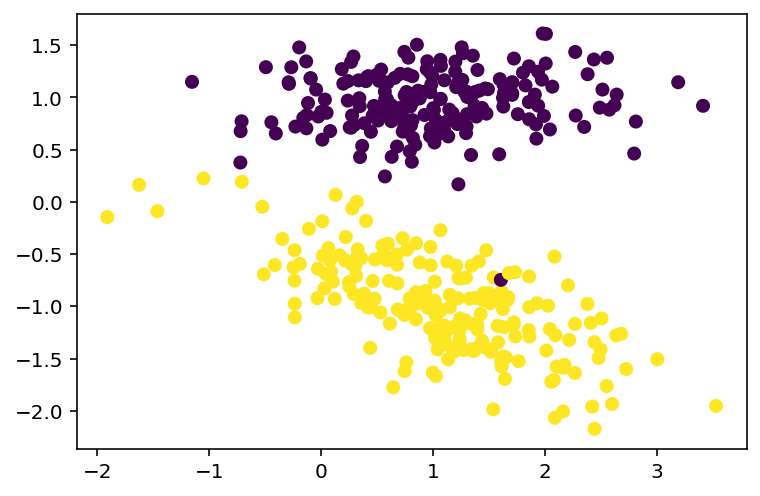

In [5]:
X, Y = make_classification(n_classes=2, n_samples=400, n_clusters_per_class=1, random_state=3, n_features=2, n_informative=2, n_redundant=0)

Y[Y==0] = -1 ## Convert Y-Labels into {1,-1}
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

Now we can instantiate a model with a large $C$ value (a hard margin) and train it on our toy data.

In [6]:
mySVM = SVM_Model(C=1000)
W, b, losses = mySVM.fit(X, Y, maxItr=100)
print(losses[0])
print(losses[-1])

400.0
19.78032551057937


The descent process of the cost function is as follows: 

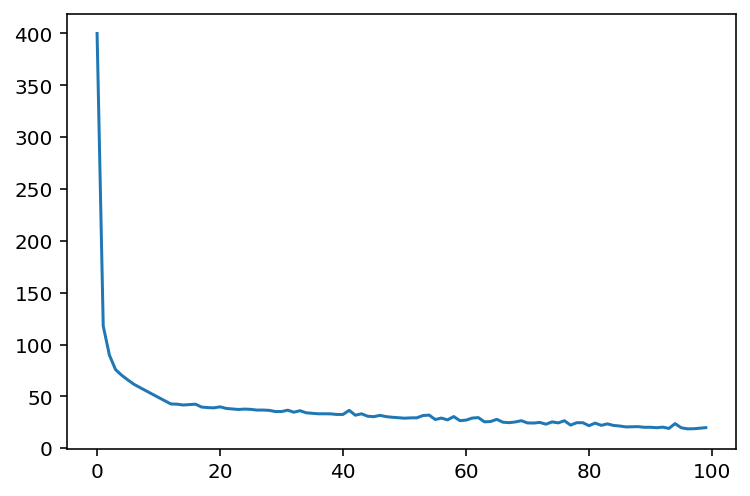

In [7]:
plt.plot(losses)
plt.show()

The weight and bias term value obtained can be shown as:

In [12]:
W, B = mySVM.W, mySVM.b
print(W, B)

[[-11.46374481 -36.8054858 ]] 4.0


Before we dive into the algorithm, here is a function to plot the decision boundary of our model on a given axis. This will be useful later to see the influence of hyperparam $C$. 

In [10]:
def plotHyperplane(w1, w2, b):
    plt.figure(figsize=(8, 8))
    x_1 = np.linspace(-2, 4, 10)
    x_2 = -(w1*x_1+b)/w2   # WT + B = 0 
    x_p = -(w1*x_1+b+1)/w2 # WT + B = -1
    x_n = -(w1*x_1+b-1)/w2 # WT + B = +1
    plt.plot(x_1, x_2, label="Hyperplane WX+B=0")
    plt.plot(x_1, x_p, label="+ve Hyperplane WX+B=1")
    plt.plot(x_1, x_n, label="-ve Hyperplane WX+B=-1")
    plt.legend()
    plt.scatter(X[:,0], X[:,1], c=Y)
    plt.show()


Let's see what the decision boundary looks like.

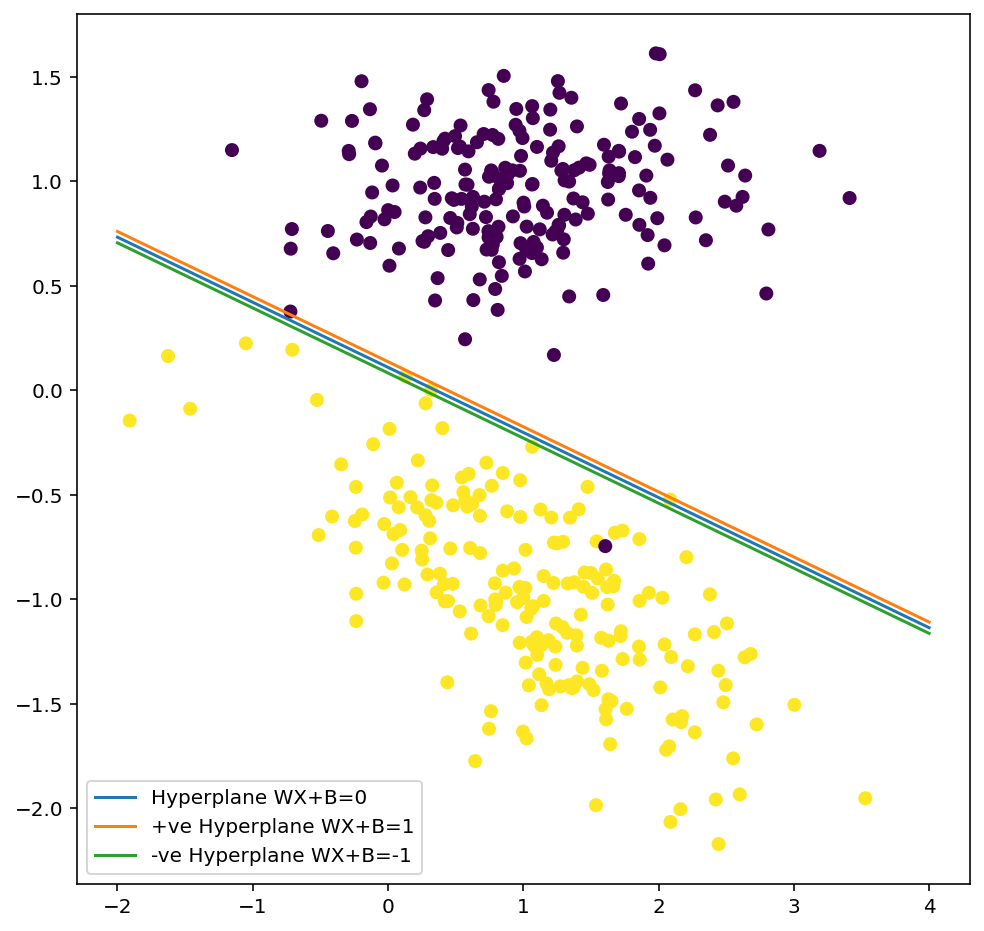

In [13]:
plotHyperplane(W[0,0],W[0,1],B)

Then we use a small $C$ value (a soft margin).

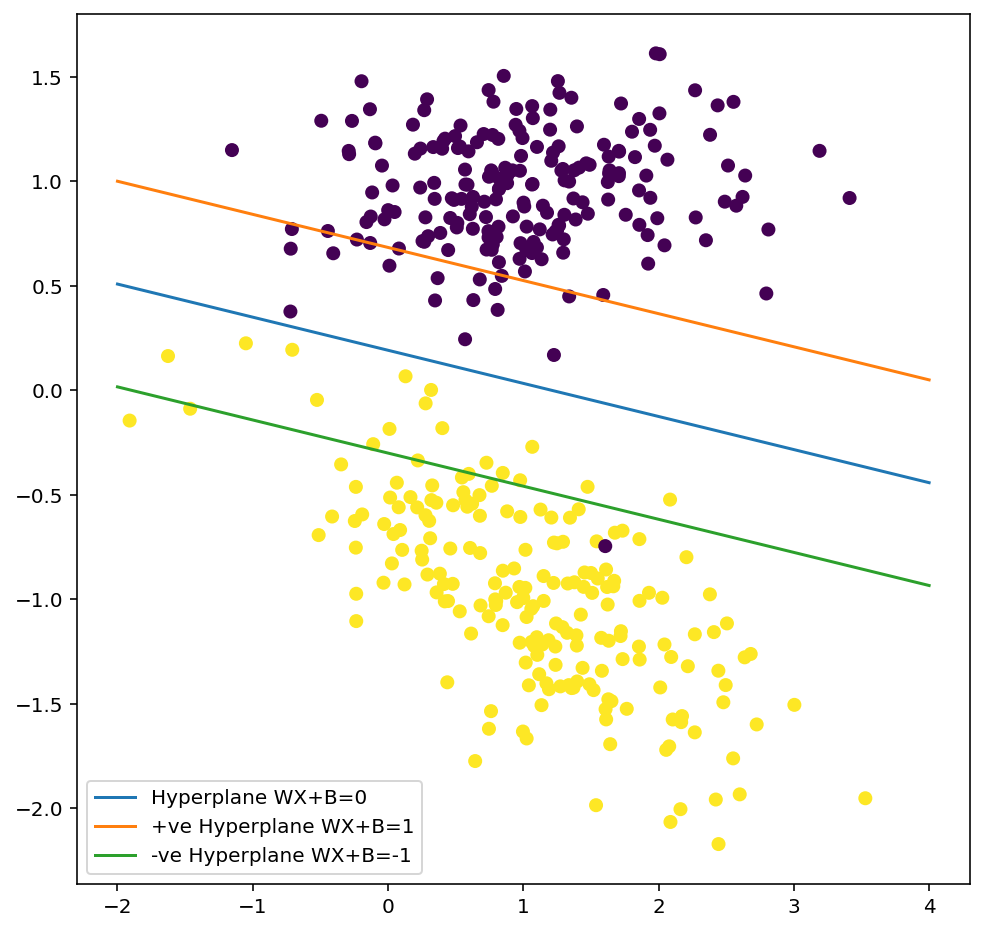

In [14]:
mySVM = SVM_Model(C=1)
W, b, losses = mySVM.fit(X, Y, maxItr=100)
W, B = mySVM.W, mySVM.b
plotHyperplane(W[0,0],W[0,1],B)

## 3. Conclusion

We have successfully implemented a mini-batch SGD solution to the optimization problem of the optimal form of SVM. We were also able to introduce the affect of the regularization param $C$. This helps our model generalize to new, unseen data.

*In fact, kernel tricks are often used under the dual form of SVM. And [here](https://stats.stackexchange.com/questions/46457/kernel-svm-in-primal-training-with-stochastic-gradient-descent) is a material to use kernels in SGD.*

# Optional Material: SMO Algorithm and Kernel Tricks

## 1. Mathematical Formulation

### 1.1 Dual Form
Using Lagrange duality, the optimization problem of SVM can be reformulated into the dual form:

$$\max_{\pmb{\alpha}}; g(\pmb{\alpha}) = \sum_{i=1}^M \alpha_i - \frac{1}{2}\sum_{i,j=1}^M y^{(i)}y^{(j)}\alpha_i\alpha_j\langle \textbf{x}^{(i)}, \textbf{x}^{(j)}\rangle$$

This problem is subject to the following two constraints:

$$0 \leq \alpha_i \leq C, \; i = 1,...,M$$
$$\sum_{i=1}^M \alpha_iy^{(i)} = 0$$

where

* $M$ is the number of training examples
* $\textbf{x}^{(i)}$ is the $i$-th training example feature vector
* $\langle \textbf{x}^{(i)}, \textbf{x}^{(j)} \rangle$ represents the inner product of the $\textbf{x}^{(i)}$ and $\textbf{x}^{(j)}$ feature vectors
* $y^{(i)}$ is the class for the $i$-th training example
* $\alpha_i$ is the Lagrange multiplier associated with the $i$-th training example
* $C$ is a regularization parameter (larger values introduce less regularization)

When using a kernel $K(\textbf{x}^{(i)}, \textbf{x}^{(j)})$, with feature mapping function $\phi(\textbf{x})$, $\langle \textbf{x}^{(i)}, \textbf{x}^{(j)}\rangle$ is replaced with $\langle \phi(\textbf{x}^{(i)}), \phi(\textbf{x}^{(j)}) \rangle$.

When using the dual form, the SVM decision function is the following:

$$f(\textbf{x}) = \sum^M_{i=1} \alpha_i y^{(i)} \langle \textbf{x}^{(i)}, \textbf{x} \rangle + b$$

where $b$ is a scalar bias term we will calculate when training our model.

## 2. Approach

For the sake of understanding the concepts behind support vector classification, we will instead implement a version of the [Sequential Minimal Optimization (SMO)](https://en.wikipedia.org/wiki/Sequential_minimal_optimization) algorithm as described by [John Platt in 1998 [PDF]](http://research.microsoft.com/pubs/69644/tr-98-14.pdf) to solve our optimization problem.

SMO works by breaking down the dual form of the SVM optimzation problem into many smaller optimzation problems that are more easily solvable. In a nutshell, the algorithm works like this:

* Two multiplier values ($\alpha_i$ and $\alpha_j$) are selected out and their values are optimized while holding all other $\alpha$ values constant.
* Once these two are optimized, another two are chosen and optimized over.
* Choosing and optimizing repeats until the convergence, which is determined based on the problem constraints. Heuristics are used to select the two $\alpha$ values to optimize over, helping to speed up convergence. The heuristics are based on error cache that is stored while training the model.

#### What We're Looking For?

What we want out of the algorithm is a vector of $\pmb{\alpha}$ values that are mostly zeros, except the $\alpha$ elements of the corresponding support vectors. What this implies is that the resultant decision boundary will only depend on the support vectors. However, labeled examples closer to the decision boundary can exert greater influence on the solution, subject to the degree of regularization.

### 2.1 Implementation

**Goal.** Implement a two-class SVC that is able to make use of the kernel trick. Use SMO to solve the SVM optimization problem.

To do so, we will use numpy to handle our arrays, matplotlib to visualize our data, and scikit-learn to generate some toy data.


In [15]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
# This line is only needed if you have a HiDPI display
%config InlineBackend.figure_format = 'retina'

np.random.seed(0)

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

**Model.** To start off we will define a class to hold the information describing our model for convenient access.

In [16]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

**Kernels.** Next, we will define two different kernel functions for our implementations. Depending on the kernel, different decision boundaries can be constructed. We will define a linear kernel and a Gaussian (also known as radial basis function or RBF) kernel.

Our linear kernel will be defined as

$$\mathcal{K}(\textbf{x},\textbf{x}') = \textbf{x}^T\textbf{x}' + b$$

where $\textbf{x}$ and $\textbf{x}'$ are arrays of input feature vectors, and $b$ is an optional bias term we will set equal to one. This kernel calculates a pairwise linear combination of the points. Using this kernel will result in the generation of a linear decision boundary.

Our Gaussian kernel will be defined as

$$\mathcal{K}(\textbf{x},\textbf{x}') = \exp\left(-\gamma \lVert \textbf{x} - \textbf{x}' \rVert^2 \right) = \exp\left(\frac{-\lVert \textbf{x} - \textbf{x}' \rVert^2}{2\sigma^2}\right)$$

where $\sigma$ is a width parameter describing how wide the kernel is (this can be set based on the spacing between data points). This kernel calculates a Gaussian similarity between the training examples, with a value of 1 indicating that the points have exactly the same feature vector and 0 indicating dissimilar vectors. Using this kernel allows for the construction of more complex, non-linear decision boundaries.

Both of these functions should take two arrays of features and return a matrix of shape length $\textbf{x}$ by length $\textbf{x}'$. SVMs can make use of many different kernels without any change in the code to train them, as long as the matrix output by the kernel is positive, semi-definite (see [the wiki page](https://en.wikipedia.org/wiki/Definite_matrix) for more information).

What this means for our code is that our kernels need to return matrices with a certain shape.

In [46]:
def linear_kernel(x, y, b=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""
    
    return x @ y.T + b # Note the @ operator for matrix multiplication


def gaussian_kernel(x, y, sigma=1):
    """Returns the gaussian similarity of arrays `x` and `y` with
    kernel width parameter `sigma` (set to 1 by default)."""
    
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

Test that our kernels output matrices of the correct shape.

In [27]:
x_len, y_len = 5, 10

In [19]:
linear_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (x_len,y_len)

True

In [21]:
gaussian_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (5,10)

True

**Objective and Decision Functions.** Up next are the dual form of the objective function and decision function as we described above.

In [22]:
# Objective function to optimize

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""
    
    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))


# Decision function
def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

Before we dive into the algorithm, here is a function to plot the decision boundary of our model on a given axis. This will be useful later to see the results of our SMO implementation.

In [23]:
def plot_decision_boundary(model, ax, C, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""
        
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        #print(grid.shape)
        
        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.7)
        
        return grid, ax

### 2.2 SMO Algorithm

Now we will dig into the SMO algorithm to train our model. SMO is a complex algorithm, here we only gives the code, and the detailed steps can be found in [this paper](https://web.iitd.ac.in/~sumeet/tr-98-14.pdf).

The three functions used to train our model are `take_step()`, `examine_example()`, and `train()`. These are structured to work as follows:

1. The `train()` function implements selection of the first $\alpha$ to optimize via the first choice heuristic and passes this value to `examine_example()`.
2. Then `examine_example()` implements the second choice heuristic to choose the second $\alpha$ to optimize, and passes the index of both $\alpha$ values to `take_step()`.
3. Finally `take_step()` carries out the meat of the calculations and computes the two new $\alpha$ values, a new threshold $b$, and updates the error cache.

The `train()` function uses a while loop to iterate through the $\alpha$ values in a few different ways until no more optimizations can be made, at which point it returns the optimized $\alpha$ vector (embedded in an `SMOModel` object).

In [34]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [33]:
def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

In [35]:
def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

### 2.3 Using the Linear Kernel

Alright, now that we have our model impelmented, let's try it out on some toy data generated by scikit-learn's `make_blobs`.

In [29]:
X_train, y = make_blobs(n_samples=1000, centers=2,
                        n_features=2, random_state=1)

We'll also scale the data to be centered at the origin with a unit standard deviation, using scikit-learn's `StandardScaler` object.

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

Finally, we have to change the class labels to be -1 and +1 instead of 0 and 1.

In [31]:
y[y == 0] = -1

Now we can instantiate a model with a large $C$ value (a hard margin) and train it on our toy data.

In [36]:
# Set model parameters and initial values
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

np.random.seed(0)
output = train(model)

Let's see what the decision boundary looks like.

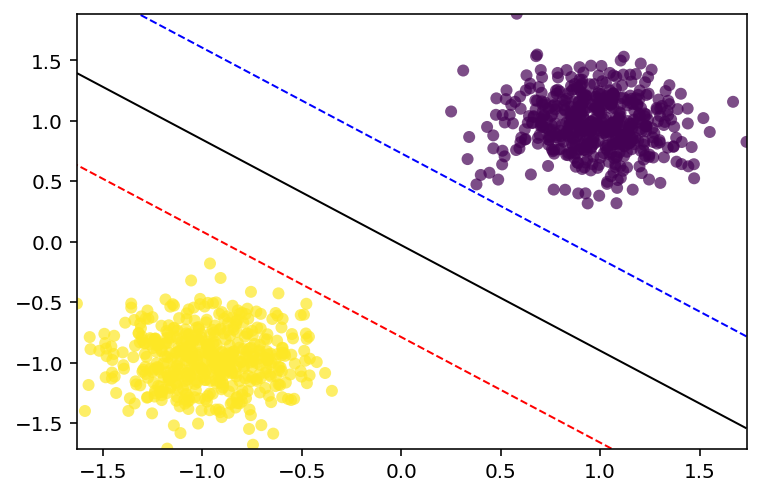

In [27]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax, C)
#print(grid.shape)

In [37]:
output.alphas.sum()

2.352566264046353

Let's see how this model performs with an outlier.

In [38]:
# Add an outlier
X_outlier = np.append(X_train_scaled, [0.1, 0.1])
X_outlier = X_outlier.reshape(X_train.shape[0]+1, X_train.shape[1])
y_outlier = np.append(y, 1)

In [39]:
# Set model parameters and initial values
C = 1000.0
m = len(X_outlier)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

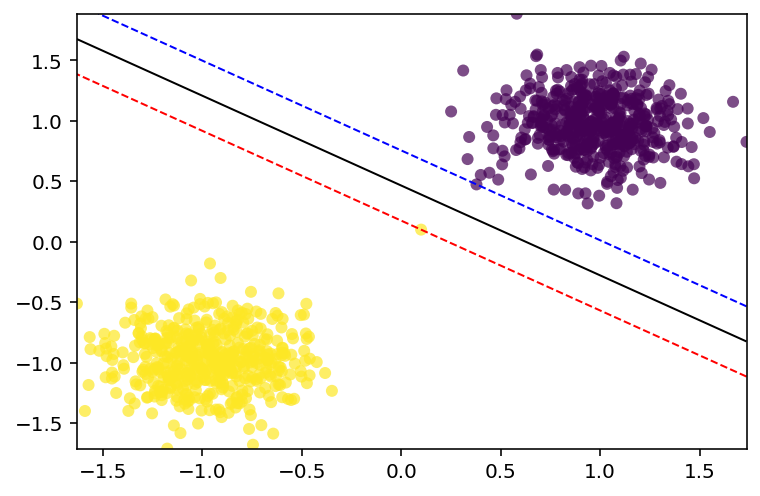

In [40]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax, C)

#### What about regularization?

We can see above that a single outlier pushes the decision boundary much farther away from the rest of the population. We can eliminate this effect if we use a softer margin (a lower value for $C$).

In [41]:
# Set model parameters and initial values
C = 0.5

initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

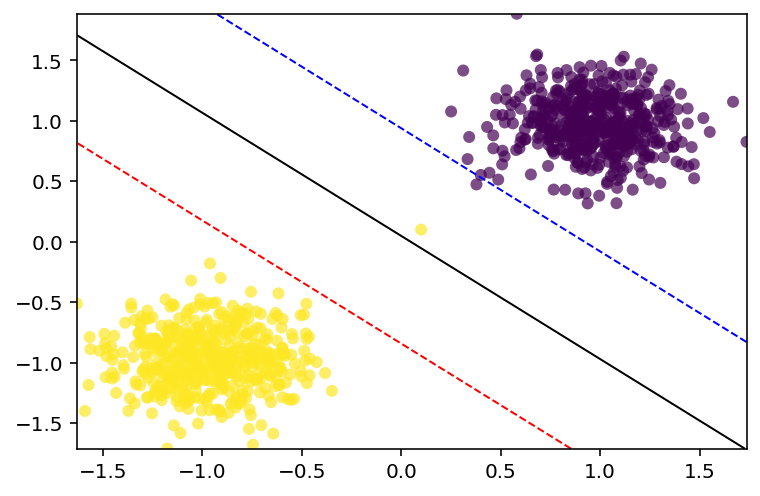

In [42]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax, C)

Now the outlier won't influence our decision boundary as much.

### 2.4 Trying out the Gaussian Kernel

Let's try out our Gaussian kernel on some data that can't be separated by a linear decision boundary, such as that generated by scikit-learn's `make_circles`.

In [43]:
X_train, y = make_circles(n_samples=500, noise=0.1,
                          factor=0.1,
                          random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [44]:
# Set model parameters and initial values
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

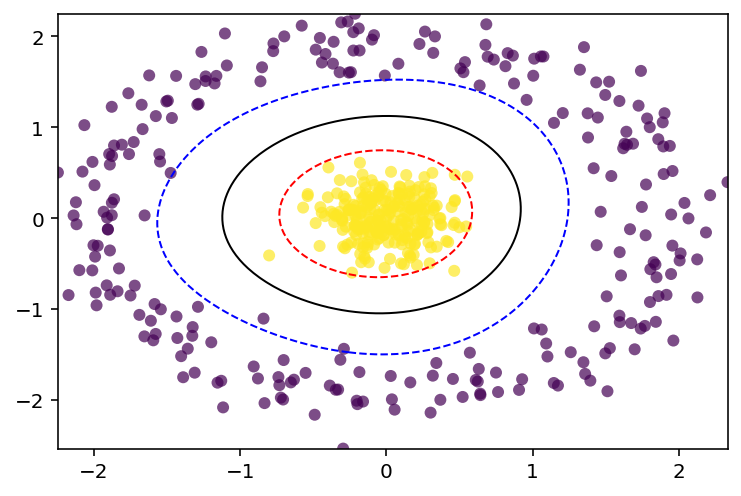

In [45]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax, C)

How about `make_moons` ?

In [37]:
X_train, y = make_moons(n_samples=500, noise=0.1,
                        random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [38]:
# Set model parameters and initial values
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, lambda x, y: gaussian_kernel(x, y, sigma=0.5),
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

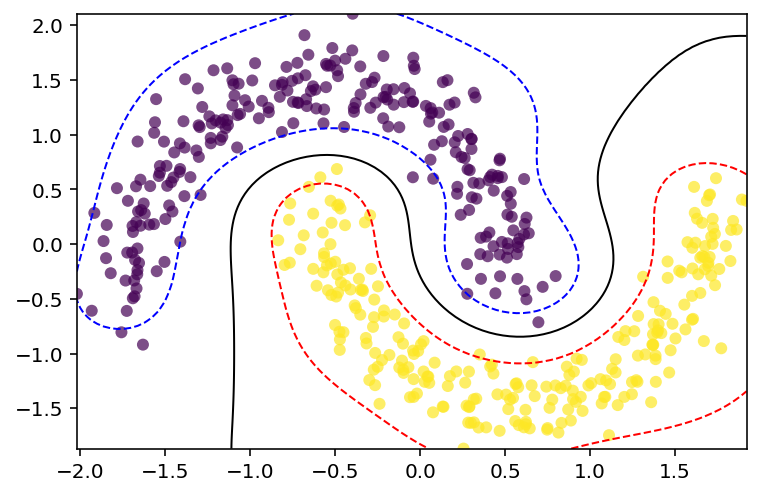

In [39]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax, C)

We've got ourselves a non-linear decision boundary. It's not perfect but this illustrates the power of the kernel trick using SVMs -- we were able to achieve a complex boundary simply by using a different feature mapping.

## 3. Conclusion

We have successfully implemented a rudimentary version of the sequential minimal optimization algorithm for solving the dual form of the general SVM optimization problem. We were also able to illustrate the “kernel trick”, which is part of what makes SVMs such a powerful tool in machine learning. Meanwhile, we introduced regularization into our model via the $C$ parameter. This helps our model generalize to new, unseen data.